# Spend on this approx. 5 hours, I think it's enogh for test task

### So what can I tell: It's overfitting on train, so it's possible it will overfit on valid too. 

# What can I do next:
* Tune model
* A lot of features, try to use neural networks
* More preprocessing, try clustering for feature reduction, calc variance etc (http://scikit-learn.org/stable/modules/feature_selection.html)
* Yeah, forgot to check for corellations, think lgb will do it for me
* I usually do pandas_profiling
* It's a common sense to look into data from bio PoW. May read papers or something just to think about more features.
* Forgot about noises in ds, don't really remember how to fix them here, it's not like plotting or just cropping data will be enough. Also lgb should fix this.

### And final point - of course we can use api from mygene.info and use some features from here, but it's boring, right? :)

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
gse24 = pd.read_csv('GSE24080.csv', index_col=0).T
gse24ann = pd.read_csv('GSE24080_annotation.csv')
gse197 = pd.read_csv('GSE19784.csv', index_col=0).T
gse197ann = pd.read_csv('GSE19784_annotation.csv')
gse197.head()

,1,10,100,1000,10000,100009676,10001,10002,10003,10004,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
GSM493958,6.867902,6.070892,8.134455,5.568788,4.738206,6.169936,5.439581,5.578937,3.483046,6.711458,...,8.027467,7.340802,7.496552,4.360529,6.190932,6.772586,5.940105,7.784046,4.413434,9.793868
GSM493959,6.395149,5.288119,8.676036,5.265260,4.650369,5.650779,5.043561,5.914312,3.616951,6.237782,...,8.822329,8.135556,8.682880,4.964215,6.303047,7.340834,5.463055,7.402748,4.443319,9.413854
GSM493960,7.213547,6.083301,8.109472,5.572229,4.889383,5.843625,4.907467,5.508685,3.496123,6.680159,...,8.281195,7.027176,7.821354,4.825616,6.409682,7.531717,5.959676,7.567631,4.453989,8.888630
GSM493962,6.661861,5.720451,6.688849,5.672341,4.409676,5.827052,5.902069,5.388580,3.503215,6.406210,...,8.894522,8.237124,8.084508,6.875271,7.406162,7.609034,6.035611,7.605073,4.899331,8.879289
GSM493963,8.186274,5.672403,8.605729,6.558532,4.797550,6.101611,5.408077,5.330433,3.523467,6.590384,...,7.923440,7.201903,8.578686,4.501544,7.358714,7.516078,5.847386,7.482892,4.583682,9.369389


In [4]:
%load_ext wurlitzer  
# for c++ output in jupyter

In [2]:
def preproc(gse24, gse24ann):
    gse24['Patient'] = gse24.index
    gse24.reset_index(drop=True, inplace=True)
    gse24ann.drop('D_Age', axis=1, inplace=True)  # Because it's broken in valid set
    gse24ann.replace({'HR_FLAG':{"TRUE":1, "FALSE":0 }, 'D_Gender':{"Male":1, "Female":0}}, inplace=True)
    gse24ann.drop(gse24ann[gse24ann['HR_FLAG'] == 'CENSORED'].index, inplace=True)  # binary, right?
    return gse24.merge(gse24ann, on='Patient').fillna(0)
train = preproc(gse24, gse24ann)

So let's build some baseline

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    train.drop(['HR_FLAG', "Patient"], axis=1).values, train['HR_FLAG'].values,
    test_size=0.2)

May be useful later

* https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst

In [5]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
#     "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':10000,
    "metric": "auc",
#     "num_leaves": 1000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True
    'early_stopping_round': 10,
}

d_train = lgb.Dataset(x_train, y_train)
d_valid = lgb.Dataset(x_test, label=y_test)
model = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = model.predict(x_test)
print(roc_auc_score(y_test.astype('int8'), y_pred))

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 71, number of negative: 375
[LightGBM] [Info] Total Bins 3056592
[LightGBM] [Info] Number of data: 446, number of used features: 20516
[LightGBM] [Info] using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.67709
Training until validation scores don't improve for 10 rounds.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.666563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.665325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.642724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's auc: 0.704644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's auc: 0.698452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's auc: 0.691641
[LightGBM] [Warn

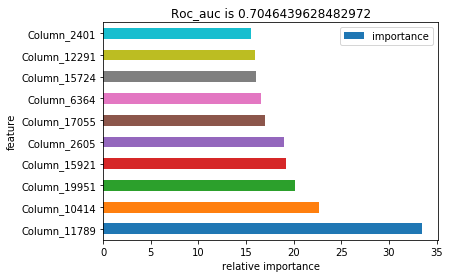

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
df_fi = pd.DataFrame(model.feature_name(), columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(roc_auc_score(y_test.astype('int8'), y_pred)))
    plt.xlabel('relative importance')
    plt.show()

So it ok, let's check on test set:

In [7]:
test = preproc(gse197, gse197ann)

y_pred = model.predict(test.drop(['HR_FLAG', "Patient"], axis=1).values)
print(roc_auc_score(test['HR_FLAG'].astype('int8'), y_pred))


0.5149307214524604


It's not ok, let's try dimensionality reduction. We'll use NMF with 'mu' because it's newest in sklearn :)

Also https://habrahabr.ru/company/ods/blog/325654/

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


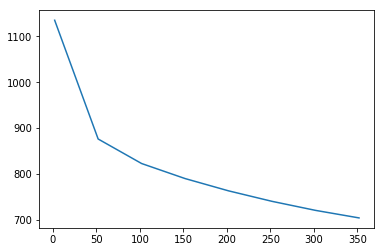

In [8]:
from sklearn.decomposition import NMF
from tqdm import tqdm_notebook as tqdm
import gc
rec_err = []
for ncomp in tqdm(range(2, 400, 50)):
    model = NMF(n_components=ncomp, solver='mu', random_state=0)
    W = model.fit_transform(x_train)
    H = model.components_
    rec_err.append(model.reconstruction_err_)
    del W, H, model
    gc.collect()
plt.plot(np.arange(2, 400, 50), rec_err)

So 100 components it is

In [22]:
from sklearn.model_selection import train_test_split
nmf = NMF(n_components=100, solver='mu', random_state=0)
W = nmf.fit_transform(train.drop(['HR_FLAG', "Patient"], axis=1).values)

x_train, x_test, y_train, y_test = train_test_split(
    W, train['HR_FLAG'].values,
    test_size=0.2)

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [35]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
verbose = 1
plot = 1
params = {
    "max_bin": 2000,
    "learning_rate": 0.0001,
    "boosting_type": "goss",
    "objective": "binary",
    'num_iterations':100000,
    "metric": "auc",
    "num_leaves": 10000,
    "verbose": 1,
    "min_data": 150,
#     "boost_from_average": True,
    'early_stopping_round': 10, 
    
}

d_train = lgb.Dataset(x_train, y_train)
d_valid = lgb.Dataset(x_test, label=y_test)
lgb = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = lgb.predict(x_test)
print(roc_auc_score(y_test.astype('int8'), y_pred))

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 70, number of negative: 376
[LightGBM] [Info] Total Bins 7519
[LightGBM] [Info] Number of data: 446, number of used features: 100
[LightGBM] [Info] using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.645981
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.645981
[3]	valid_0's auc: 0.645981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

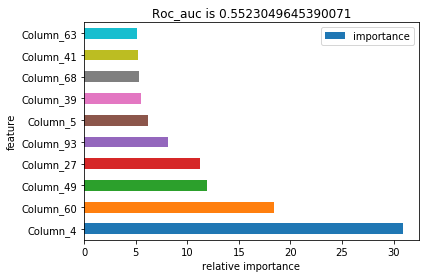

In [25]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
df_fi = pd.DataFrame(lgb.feature_name(), columns=['feature'])
df_fi['importance'] = list(lgb.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(roc_auc_score(y_test.astype('int8'), y_pred)))
    plt.xlabel('relative importance')
    plt.show()

In [26]:
w = nmf.transform(test.drop(['HR_FLAG', "Patient"], axis=1).values)
y_pred = lgb.predict(w)
print(roc_auc_score(test['HR_FLAG'].astype('int8'), y_pred))


/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.5012243191591018


## Welp

Okay, let's try putting valid right in lgb

May be useful later

* https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst

In [20]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
verbose = 1
plot = 1
params = {
    "max_bin": 1024,
    "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':10000,
    "metric": "auc",
#     "num_leaves": 1000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True
    'early_stopping_round': 10
}

d_train = lgb.Dataset(train.drop(['HR_FLAG', "Patient"], axis=1).values, train['HR_FLAG'].values)
d_valid = lgb.Dataset(test.drop(['HR_FLAG', "Patient"], axis=1).values, test['HR_FLAG'].values)
model = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = model.predict(test.drop(['HR_FLAG', "Patient"], axis=1).values)
final = roc_auc_score(test['HR_FLAG'].values, y_pred)
print(final)

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 88, number of negative: 470
[LightGBM] [Info] Total Bins 3835273
[LightGBM] [Info] Number of data: 558, number of used features: 20516
[LightGBM] [Info] using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.545658
Training until validation scores don't improve for 10 rounds.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.608935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.608397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.625448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's auc: 0.621208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's auc: 0.626881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's auc: 0.623626
[LightGBM] [War

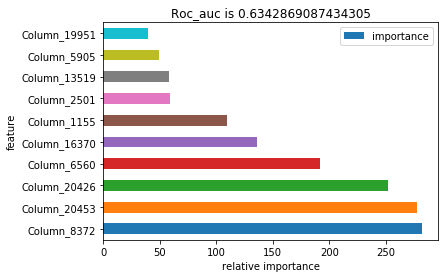

In [21]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
df_fi = pd.DataFrame(model.feature_name(), columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(final))
    plt.xlabel('relative importance')
    plt.show()

Yeah, ok, wtf

In [22]:
from sklearn.model_selection import train_test_split
nmf = NMF(n_components=100, solver='mu', random_state=0)
W = nmf.fit_transform(train.drop(['HR_FLAG', "Patient"], axis=1).values)
w = nmf.transform(test.drop(['HR_FLAG', "Patient"], axis=1).values)

# x_train, x_test, y_train, y_test = train_test_split(
#     W, train['HR_FLAG'].values,
#     test_size=0.2)

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [38]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
verbose = 1
plot = 1
params = {
#     "max_bin": 2000,
#     "learning_rate": 0.0001,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':100000,
    "metric": "auc",
#     "num_leaves": 10000,
    "verbose": 1,
#     "min_data": 150,
#     "boost_from_average": True,
    'early_stopping_round': 10, 
    
}

d_train = lgb.Dataset(W, train['HR_FLAG'].values)
d_valid = lgb.Dataset(w, test['HR_FLAG'].values)
lgb = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

# y_pred = lgb.predict(x_test)
# print(roc_auc_score(y_test.astype('int8'), y_pred))

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 88, number of negative: 470
[LightGBM] [Info] Total Bins 9321
[LightGBM] [Info] Number of data: 558, number of used features: 100
[LightGBM] [Info] using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.524427
Training until validation scores don't improve for 10 rounds.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.550854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.574534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.593586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's auc: 0.57761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's auc: 0.580148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's auc: 0.59487
[LightGBM] [Warning] N